In [1]:
import os
from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

pd.options.display.max_columns = 50

In [21]:
ORDINAL_TO_SEAT = {0: 'S', 1: 'W', 2: 'N', 3: 'E'}
SEAT_TO_ORDINAL = {y: x for x, y in ORDINAL_TO_SEAT.items()}
VALID_RANKS = 'AKQJT98765432'
ROUND_NAMES = {
    'No Hearts': 'H',
    'No Last Two': 'L',
    'Barbu': 'B',
    'No Queens': 'Q',
    'Misere': 'M',
}
ROUND_NAMES.update({
    'Dominoes from the ' + x: 'D' + y
    for x, y in zip([
        'Ace', 'King', 'Queen', 'Jack', 'Ten', 'Nine', 'Eight', 'Seven', 'Six', 'Five', 'Four', 'Three', 'Two'
    ], VALID_RANKS)
})
ROUND_NAMES.update({
    'Trumps ' + x: 'T' + y
    for x, y in zip(['Spades', 'Hearts', 'Diamonds', 'Clubs'], 'SHDC')
})
TO_SIMPLE_DOUBLE = {'0': '0', '1': '1', '2': '2', '3': '3', '4': '0', '5': '1', '6': '2', '7': '3'}
ACTIONS = {
    '': '',
    'Pass': '',
    'Double S': '0',
    'Double W': '1',
    'Double N': '2',
    'Double E': '3',
    'Double S and W': '01',
    'Double S and N': '02',
    'Double S and E': '03',
    'Double W and S': '01',
    'Double W and N': '12',
    'Double W and E': '13',
    'Double N and S': '02',
    'Double N and W': '12',
    'Double N and E': '23',
    'Double E and S': '03',
    'Double E and W': '13',
    'Double E and N': '23',
    'Redouble S': '4',
    'Redouble W': '5',
    'Redouble N': '6',
    'Redouble E': '7',
    'D S and RD W': '05',
    'D S and RD N': '06',
    'D S and RD E': '07',
    'D W and RD S': '14',
    'D W and RD N': '16',
    'D W and RD E': '17',
    'D N and RD S': '24',
    'D N and RD W': '25',
    'D N and RD E': '27',
    'D E and RD S': '34',
    'D E and RD W': '35',
    'D E and RD N': '36',
    'Redouble S and W': '45',
    'Redouble S and N': '46',
    'Redouble S and E': '47',
    'Redouble W and S': '45',
    'Redouble W and N': '56',
    'Redouble W and E': '57',
    'Redouble N and S': '46',
    'Redouble N and W': '56',
    'Redouble N and E': '67',
    'Redouble E and S': '47',
    'Redouble E and W': '57',
    'Redouble E and N': '67',
}

def add_double(doubling_matrix, i, j):
    doubling_matrix[i,j] -= 1
    doubling_matrix[j,i] -= 1
    doubling_matrix[i,i] += 1
    doubling_matrix[j,j] += 1
    return doubling_matrix

class PlayerRound:
    def __init__(
        self, player_name, player_ordinal, hand, round_name, remaining_round_names,
        dealer_ordinal, actions, cards_played, scores
    ):
        self.player_name = player_name
        self.player_ordinal = player_ordinal
        self.hand = hand
        self.round_name = round_name
        self.remaining_round_names = remaining_round_names
        self.dealer_ordinal = dealer_ordinal
        self.actions = actions
        self.cards_played = cards_played
        self.scores = scores
        self.doubles = {
            '01': 0, '02': 0, '03': 0, '12': 0, '13': 0, '23': 0, '10': 0, '20': 0, '30': 0, '21': 0, '31': 0, '32': 0,
        }
        
    @property
    def score(self):
        return self.scores[self.player_ordinal]
        
    @property
    def is_dealer(self):
        return self.player_ordinal == self.dealer_ordinal
        
    def hand_to_str(self):
        return ' '.join([y + ''.join([x[1] for x in self.hand if x[0] == y]) for y in 'shdc'])
        
    def remaining_rounds_to_str(self):
        return str([''.join(x) for x in self.remaining_round_names])
        
    def __repr__(self):
        return self.player_name + ' P' + str(self.player_ordinal) + ' ' + self.hand_to_str() + ' ' + \
            self.round_name + ' ' + self.remaining_rounds_to_str() + ' Dealer: ' + str(self.dealer_ordinal) + \
            ' ' + str(self.actions) + ' ' + str(self.score)
    
    def _parse_actions(self):
        actions_numeric = [None] * 4
        doubling_matrix = np.eye(4)
        for i, _action in enumerate(self.actions):    # starts from person on dealer's right
            ordinal = (i + self.dealer_ordinal + 1) % 4
            if _action != 'Max':
                action = ACTIONS[_action]
                for x in action:
                    assert str(TO_SIMPLE_DOUBLE[x]) != str(ordinal), str(ordinal) + ' ' + _action + ' ' + str(action) + ' ' + str(x)
                    self.doubles[TO_SIMPLE_DOUBLE[x] + str(ordinal)] += 1
                    self.doubles[str(ordinal) + TO_SIMPLE_DOUBLE[x]] += 1
            else:
                action = ''
                for p in range(4):
                    if p == ordinal:
                        continue
                    action += (str(p) if self.doubles[str(p) + str(ordinal)] == 0 else str(p+4))
                    self.doubles[str(p) + str(ordinal)] += 1
                    self.doubles[str(ordinal) + str(p)] += 1
            actions_numeric[ordinal] = action
            
        for double_code, num_times in self.doubles.items():
            if double_code[0] > double_code[1]:
                continue
            first = int(double_code[0])
            second = int(double_code[1])
            for i in range(num_times):
                doubling_matrix = add_double(doubling_matrix, first, second)
        return actions_numeric, doubling_matrix
    
    def __str__(self):
        return self.__repr__()
    
    @property
    def __dict__(self):
        actions_numeric, doubling_matrix = self._parse_actions()
        raw_scores = np.matrix(self.scores) * np.linalg.inv(doubling_matrix)
        return {
            'player_name': self.player_name,
            'player': self.player_ordinal,
            'round_num': 27 - len([x for lst in self.remaining_round_names for x in lst]),
            'dealer': self.dealer_ordinal,
            'round': self.round_name[0],
            'round_name': self.round_name,
            'score': self.score,
            'raw_score': round(raw_scores[0,self.player_ordinal]),
            'c': ''.join([x[1] for x in self.hand if x[0] == 'c']),
            'd': ''.join([x[1] for x in self.hand if x[0] == 'd']),
            's': ''.join([x[1] for x in self.hand if x[0] == 's']),
            'h': ''.join([x[1] for x in self.hand if x[0] == 'h']),
            'call_ordinal': 6 - len(self.remaining_round_names[self.dealer_ordinal]),
            'remaining0': ''.join(self.remaining_round_names[0]),
            'remaining1': ''.join(self.remaining_round_names[1]),
            'remaining2': ''.join(self.remaining_round_names[2]),
            'remaining3': ''.join(self.remaining_round_names[3]),
            'action0': actions_numeric[0],
            'action1': actions_numeric[1],
            'action2': actions_numeric[2],
            'action3': actions_numeric[3],
            '01': self.doubles['01'],
            '02': self.doubles['02'],
            '03': self.doubles['03'],
            '12': self.doubles['12'],
            '13': self.doubles['13'],
            '23': self.doubles['23'],
            'cards_played0': self.cards_played[0],
            'cards_played1': self.cards_played[1],
            'cards_played2': self.cards_played[2],
            'cards_played3': self.cards_played[3]
        }

In [22]:

class BarbuParser:
    def __init__(self, files, verbose=False):
        self.player_rounds = []
        for file in files:
            self.player_rounds.extend(self.parse_game(file, verbose=verbose))
        
    @property
    def df(self):
        return pd.DataFrame([x.__dict__ for x in self.player_rounds])
        
    def parse_game(self, file, verbose=False):
        with open(file, 'r') as f:
            self.data = f.readlines()
        
        preamble = self.data[:11]
        gameplay = self.data[11:]
        
        player_rounds = []
        player_names = []
        for line_num in [5,6,7,8]:
            player_names.append(preamble[line_num].split(':')[-1].strip().split(' (')[0])
        
        if verbose:
            print(file, player_names)

        total_scores = [0, 0, 0, 0]
        remaining_round_names = [
            {'H', 'L', 'B', 'Q', 'M', 'D', 'T'},
            {'H', 'L', 'B', 'Q', 'M', 'D', 'T'},
            {'H', 'L', 'B', 'Q', 'M', 'D', 'T'},
            {'H', 'L', 'B', 'Q', 'M', 'D', 'T'}
        ]
        pages = []
        page = []
        for x in gameplay:
            if ('-' * 60) in x:
                pages.append(page)
                page = []
            else:
                page.append(x[:-1])
        
        for page in pages[0:]:
            if not page[0].startswith('Deal'):
                break
            
            dealer_ordinal = SEAT_TO_ORDINAL[page[1][-1]]
            north = ['s' + x.lower() for x in page[2].strip() if x in VALID_RANKS] + \
                ['h' + x.lower() for x in page[3].strip() if x in VALID_RANKS] + \
                ['d' + x.lower() for x in page[4].strip() if x in VALID_RANKS] + \
                ['c' + x.lower() for x in page[5].strip() if x in VALID_RANKS]
            west = []
            east = []
            for suit, line in zip('shdc', range(6,10)):
                w, e = page[line].split()
                west.extend([suit + x.lower() for x in w if x in VALID_RANKS])
                east.extend([suit + x.lower() for x in e if x in VALID_RANKS])
            
            south = ['s' + x.lower() for x in page[10].strip() if x in VALID_RANKS] + \
                ['h' + x.lower() for x in page[11].strip() if x in VALID_RANKS] + \
                ['d' + x.lower() for x in page[12].strip() if x in VALID_RANKS] + \
                ['c' + x.lower() for x in page[13].strip() if x in VALID_RANKS]
            
            hands = [south, west, north, east]
            round_name = ROUND_NAMES[page[15]]
            if round_name[0] in 'TD':
                remaining_round_names[dealer_ordinal].remove(round_name[0])
            else:
                remaining_round_names[dealer_ordinal].remove(round_name)
                
            actions = ['', '', '', '']
            for line in range(16, 20):
                # ordinal = (dealer_ordinal + line - 15) % 4
                actions[line - 16] = page[line].strip()
            
            cards_played = [[], [], [], []]
            for line in range(21, 21+100):
                if set(page[line]) == {' ', 'N', 'E', 'S', 'W'}:
                    continue
    
                if page[line].strip() == '':
                    break
                    
                s_begin = 5 * ((0 - dealer_ordinal) % 4) + 3
                w_begin = 5 * ((1 - dealer_ordinal) % 4) + 3
                n_begin = 5 * ((2 - dealer_ordinal) % 4) + 3
                e_begin = 5 * ((3 - dealer_ordinal) % 4) + 3
                cards_played[0].append(page[line][s_begin:s_begin+2])
                cards_played[1].append(page[line][w_begin:w_begin+2])
                cards_played[2].append(page[line][n_begin:n_begin+2])
                cards_played[3].append(page[line][e_begin:e_begin+2])
            
            scores_starting_dealer_ordinal = [int(x) for x in page[line+1].split()]
            scores = scores_starting_dealer_ordinal[-dealer_ordinal:] + scores_starting_dealer_ordinal[:-dealer_ordinal]
            for i in range(4):
                total_scores[i] += scores[i]
                
            if verbose:
                print('S', ' '.join(south) + '  ' + ' '.join(remaining_round_names[0]))
                print('W', ' '.join(west) + '  ' + ' '.join(remaining_round_names[1]))
                print('N', ' '.join(north) + '  ' + ' '.join(remaining_round_names[2]))
                print('E', ' '.join(east) + '  ' + ' '.join(remaining_round_names[3]))

                print('Dealer', ORDINAL_TO_SEAT[dealer_ordinal])
                print(round_name)
                print(actions)

                print(cards_played[0])
                print(cards_played[1])
                print(cards_played[2])
                print(cards_played[3])
                print(scores)
                print(total_scores)
                print('------------------------------')
                
            player_rounds.extend([
                PlayerRound(player_names[i], i, hands[i], round_name, deepcopy(remaining_round_names),
                    dealer_ordinal, actions, cards_played, scores)
                for i in range(4)
            ])
                
        return player_rounds
    
game_files = [x for x in os.listdir('.') if x.endswith('txt')]
parser = BarbuParser(game_files, verbose=False)
print(len(parser.player_rounds))

19040


In [168]:
distributions = [
    (4,3,3,3), (4,4,3,2), (5,3,3,2), (4,4,4,1), (5,4,2,2), (5,4,3,1),
    (5,4,4,0), (5,5,2,1), (6,3,2,2), (6,3,3,1), (5,5,3,0), (6,4,2,1),
    (6,4,3,0), (6,5,1,1), (6,5,2,0), (7,2,2,2), (7,3,2,1), (7,3,3,0),
    (7,4,1,1), (7,4,2,0), (6,6,1,0), (7,5,1,0), (8,2,2,1), (8,3,1,1),
    (8,3,2,0), (7,6,0,0), (8,4,1,0), (8,5,0,0), (9,2,1,1), (9,2,2,0),
    (9,3,1,0), (9,4,0,0), (10,1,1,1), (10,2,1,0), (10,3,0,0), (11,1,1,0), (11,2,0,0), (12,1,0,0), (13,0,0,0)
]

def rank_distribution(x):
    p = 2
    return x[0]**p + x[1]**p + x[2]**p + x[3]**p

for x in sorted(distributions, key=lambda x: rank_distribution(x)):
    print(x, rank_distribution(x))

(4, 3, 3, 3) 43
(4, 4, 3, 2) 45
(5, 3, 3, 2) 47
(4, 4, 4, 1) 49
(5, 4, 2, 2) 49
(5, 4, 3, 1) 51
(6, 3, 2, 2) 53
(5, 5, 2, 1) 55
(6, 3, 3, 1) 55
(5, 4, 4, 0) 57
(6, 4, 2, 1) 57
(5, 5, 3, 0) 59
(6, 4, 3, 0) 61
(7, 2, 2, 2) 61
(6, 5, 1, 1) 63
(7, 3, 2, 1) 63
(6, 5, 2, 0) 65
(7, 3, 3, 0) 67
(7, 4, 1, 1) 67
(7, 4, 2, 0) 69
(6, 6, 1, 0) 73
(8, 2, 2, 1) 73
(7, 5, 1, 0) 75
(8, 3, 1, 1) 75
(8, 3, 2, 0) 77
(8, 4, 1, 0) 81
(7, 6, 0, 0) 85
(9, 2, 1, 1) 87
(8, 5, 0, 0) 89
(9, 2, 2, 0) 89
(9, 3, 1, 0) 91
(9, 4, 0, 0) 97
(10, 1, 1, 1) 103
(10, 2, 1, 0) 105
(10, 3, 0, 0) 109
(11, 1, 1, 0) 123
(11, 2, 0, 0) 125
(12, 1, 0, 0) 145
(13, 0, 0, 0) 169


In [48]:
sorted(distributions, key=lambda x: x[0]**1.6 + x[1]**1.6 + x[2]**1.6 + x[3]**1.6)

[(4, 3, 3, 3),
 (4, 4, 3, 2),
 (5, 3, 3, 2),
 (5, 4, 2, 2),
 (4, 4, 4, 1),
 (5, 4, 3, 1),
 (6, 3, 2, 2),
 (6, 3, 3, 1),
 (5, 5, 2, 1),
 (6, 4, 2, 1),
 (5, 4, 4, 0),
 (7, 2, 2, 2),
 (5, 5, 3, 0),
 (7, 3, 2, 1),
 (6, 4, 3, 0),
 (6, 5, 1, 1),
 (7, 4, 1, 1),
 (6, 5, 2, 0),
 (7, 3, 3, 0),
 (7, 4, 2, 0),
 (8, 2, 2, 1),
 (8, 3, 1, 1),
 (6, 6, 1, 0),
 (7, 5, 1, 0),
 (8, 3, 2, 0),
 (8, 4, 1, 0),
 (9, 2, 1, 1),
 (9, 2, 2, 0),
 (7, 6, 0, 0),
 (9, 3, 1, 0),
 (8, 5, 0, 0),
 (10, 1, 1, 1),
 (9, 4, 0, 0),
 (10, 2, 1, 0),
 (10, 3, 0, 0),
 (11, 1, 1, 0),
 (11, 2, 0, 0),
 (12, 1, 0, 0),
 (13, 0, 0, 0)]

In [136]:
def add_features(_df):
    df = _df.copy()
    df['dealer_position'] = (df['player'] - df['dealer']) % 4
    df['num_h'] = df['h'].str.len()
    for rank in 'akq432':
        df['num_' + rank] = df['c'].str.contains(rank).astype(int) + df['d'].str.contains(rank) + df['s'].str.contains(rank) + df['h'].str.contains(rank)
    
    df['highs'] = df['num_a'] * 4 + df['num_k'] * 2 + df['num_q']
    df['lows'] = df['num_2'] * 4 + df['num_3'] * 2 + df['num_4']
    df['ends'] = df['highs'] + df['lows']
    df['num_players_doubled'] = df.apply(lambda row: len(row['action' + str(row['player'])]), axis=1)
    df['distribution'] = (df['c'].str.len() ** 2 + df['d'].str.len() ** 2 + df['s'].str.len() ** 2 + df['h'].str.len() ** 2)
    return df

df = add_features(parser.df)
good_players = [
    'Alessio Isaia', 'Ben Kristensen', 'David Halasi', 'fabio quai', 'geoff hampson', 'John Diamond',
    'Kit Woolsey', 'Mark Tynkov', 'mark tynkov', 'Mike Rice', 'Steven De Donder'
]
good_players_df = df[df.player_name.isin(good_players)]
df.head(5)

,player_name,player,round_num,dealer,round,round_name,score,raw_score,c,d,s,h,call_ordinal,remaining0,remaining1,remaining2,remaining3,action0,action1,action2,action3,01,02,03,12,13,23,cards_played0,cards_played1,cards_played2,cards_played3,dealer_position,num_h,num_a,num_k,num_q,num_4,num_3,num_2,highs,lows,ends,num_players_doubled,distribution
0,Beppe Mistretta,0,0,0,H,H,0,-2,43,qt9,t52,aqt32,0,LDMQTB,LDMQTBH,LDMQTBH,LDMQTBH,,,457,,0,2,0,2,0,2,"[dq, st, s5, c4, c3, dt, d9, ha, hq, s2, h2, h...","[d8, sq, sj, cj, c8, dj, c6, d3, d6, s7, h5, h...","[da, sa, s8, c9, ca, d7, c2, sk, s6, s4, h4, h...","[d5, s9, s3, ck, cq, dk, ct, d4, d2, hj, h8, c...",0,5,1,0,2,1,2,2,6,13,19,0,47
1,Alessio Isaia,1,0,0,H,H,-8,-5,j86,j863,qj7,k95,0,LDMQTB,LDMQTBH,LDMQTBH,LDMQTBH,,,457,,0,2,0,2,0,2,"[dq, st, s5, c4, c3, dt, d9, ha, hq, s2, h2, h...","[d8, sq, sj, cj, c8, dj, c6, d3, d6, s7, h5, h...","[da, sa, s8, c9, ca, d7, c2, sk, s6, s4, h4, h...","[d5, s9, s3, ck, cq, dk, ct, d4, d2, hj, h8, c...",1,3,0,1,1,0,1,0,3,2,5,0,43
2,Ben Kristensen,2,0,0,H,H,30,-3,a92,a7,ak864,764,0,LDMQTB,LDMQTBH,LDMQTBH,LDMQTBH,,,457,,0,2,0,2,0,2,"[dq, st, s5, c4, c3, dt, d9, ha, hq, s2, h2, h...","[d8, sq, sj, cj, c8, dj, c6, d3, d6, s7, h5, h...","[da, sa, s8, c9, ca, d7, c2, sk, s6, s4, h4, h...","[d5, s9, s3, ck, cq, dk, ct, d4, d2, hj, h8, c...",2,3,3,1,0,2,0,1,14,6,20,3,47
3,Kevin Zhou,3,0,0,H,H,-52,-20,kqt75,k542,93,j8,0,LDMQTB,LDMQTBH,LDMQTBH,LDMQTBH,,,457,,0,2,0,2,0,2,"[dq, st, s5, c4, c3, dt, d9, ha, hq, s2, h2, h...","[d8, sq, sj, cj, c8, dj, c6, d3, d6, s7, h5, h...","[da, sa, s8, c9, ca, d7, c2, sk, s6, s4, h4, h...","[d5, s9, s3, ck, cq, dk, ct, d4, d2, hj, h8, c...",3,2,0,2,1,1,1,1,5,7,12,0,49
4,Beppe Mistretta,0,1,1,H,H,0,-3,t2,982,jt75,qj96,0,LDMQTB,LDMQTB,LDMQTBH,LDMQTBH,,,03,,0,2,0,0,0,2,"[st, ct, sj, s7, s5, d9, c2, d8, d2, h9, hq, h...","[sq, ca, s9, s8, c7, dk, c6, d5, d4, h7, ha, h...","[sa, c9, s2, dq, dj, da, ck, c8, d6, h4, hk, h...","[s6, cj, s4, sk, s3, dt, cq, c5, d3, ht, c3, d...",3,4,0,0,1,0,0,2,1,8,9,0,45


In [172]:
z = df[(df.dealer_position == 0) & (df.round == 'H')]
z[z.round == 'H']

,player_name,player,round_num,dealer,round,round_name,score,raw_score,c,d,s,h,call_ordinal,remaining0,remaining1,remaining2,remaining3,action0,action1,action2,action3,01,02,03,12,13,23,cards_played0,cards_played1,cards_played2,cards_played3,dealer_position,num_h,num_a,num_k,num_q,num_4,num_3,num_2,highs,lows,ends,num_players_doubled,distribution
0,Beppe Mistretta,0,0,0,H,H,0,-2,43,qt9,t52,aqt32,0,LDMQTB,LDMQTBH,LDMQTBH,LDMQTBH,,,457,,0,2,0,2,0,2,"[dq, st, s5, c4, c3, dt, d9, ha, hq, s2, h2, h...","[d8, sq, sj, cj, c8, dj, c6, d3, d6, s7, h5, h...","[da, sa, s8, c9, ca, d7, c2, sk, s6, s4, h4, h...","[d5, s9, s3, ck, cq, dk, ct, d4, d2, hj, h8, c...",0,5,1,0,2,1,2,2,6,13,19,0,47
5,Alessio Isaia,1,1,1,H,H,0,0,a76,k54,q98,a753,0,LDMQTB,LDMQTB,LDMQTBH,LDMQTBH,,,03,,0,2,0,0,0,2,"[st, ct, sj, s7, s5, d9, c2, d8, d2, h9, hq, h...","[sq, ca, s9, s8, c7, dk, c6, d5, d4, h7, ha, h...","[sa, c9, s2, dq, dj, da, ck, c8, d6, h4, hk, h...","[s6, cj, s4, sk, s3, dt, cq, c5, d3, ht, c3, d...",0,4,2,1,1,1,1,0,11,3,14,0,43
10,Ben Kristensen,2,2,2,Q,Q,24,-3,6,95,kj872,qt953,0,LDMQTB,LDMQTB,LDMTBH,LDMQTBH,12,,47,456,2,4,2,0,2,4,"[d8, ca, h7, st, ck, h4, s3, c5, ct, da, d6]","[dj, cj, hj, sa, c9, h6, sq, c8, c2, hk, dq]","[d9, c6, ht, sk, d5, h5, sj, s8, hq, h9, s7]","[dt, c7, ha, s9, c4, h8, s6, c3, cq, h2, d2]",0,5,0,1,1,0,1,1,3,6,9,2,55
15,Kevin Zhou,3,3,3,M,M,14,-4,qt7,854,q72,t762,0,LDMQTB,LDMQTB,LDMTBH,LDQTBH,567,,1,4,2,2,4,2,0,0,"[d3, dt, d2, h9, h5, ca, s9, s8, s5, h3, hk, s...","[dk, dq, dj, h8, ha, c5, s4, st, hj, cj, c9, c...","[d9, d7, d6, hq, h4, c6, sk, sj, s3, ck, c8, d...","[d5, d8, d4, ht, h6, cq, sq, s7, s2, h7, h2, c...",0,4,0,0,2,1,0,2,2,9,11,1,43
16,Beppe Mistretta,0,4,0,L,L,0,-2,qj642,k743,q95,j,1,DMQTB,LDMQTB,LDMTBH,LDQTBH,,467,,,2,0,0,2,2,0,"[s9, hj, sq, d7, d3, s5, cq, dk, c6, cj, c4, c...","[sj, ha, h8, d2, c9, h6, ca, hq, sa, c7, s4, s...","[s6, ht, h5, dt, da, h9, c8, h3, c5, dj, dq, d...","[s7, h7, hk, d6, d5, h4, ct, h2, st, ck, s8, s...",0,1,0,1,2,2,1,1,4,8,12,0,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19023,Fabrizio Farnesi,3,23,3,T,TD,10,10,qj2,qt75,a653,qj,5,M,H,Q,D,,,,,0,0,0,0,0,0,"[h5, h6, d8, st, s4, d9, c8, dj, ck, c3, sj, d...","[ht, hk, h2, sq, sk, h4, ca, h9, c4, c7, s9, d...","[ha, h3, h7, s2, s7, h8, c5, d2, c6, c9, d3, d...","[hq, hj, d5, sa, s3, d7, c2, dt, cq, cj, s5, d...",0,2,1,0,3,0,1,1,7,6,13,0,45
19024,Mark Tynkov,0,24,0,M,M,-34,-11,aqt4,t93,a9,j985,6,,H,Q,D,,467,,456,2,0,2,2,4,2,"[s9, sa, d9, h8, ca, cq, h9, h5, hj, c4, d3, d...","[s7, st, d8, hq, s5, c6, dq, dj, d4, c2, cj, c...","[s8, sk, d7, ht, s3, ha, hk, h6, h7, dk, d2, d...","[s6, sq, da, h2, s4, ck, h3, h4, sj, c3, s2, c...",0,4,2,0,1,1,1,0,9,3,12,0,45
19029,Umberto Prestini,1,25,1,H,H,-22,-6,qt53,83,t98,a765,6,,,Q,D,,67,457,456,0,2,2,4,4,4,"[sk, ca, cj, c6, d5, c4, s7, s5, s6, s3, h4, h...","[s9, ct, cq, c5, d8, d3, st, s8, ha, c3, h7, h...","[s4, c8, ck, c7, d9, d6, hj, h2, da, dk, dt, d...","[sq, c9, c2, dq, dj, d7, sj, sa, s2, ht, h3, h...",0,4,1,0,1,0,2,0,5,4,9,2,45
19034,Sami Casanova,2,26,2,Q,Q,-36,-9,kj,q42,akj65,962,6,,,,D,12,2,,456,2,2,2,2,2,2,"[ht, h5, da, h3, ca, dt, ct, d5, cq, ha, hk, c5]","[hq, h8, s8, dk, c9, d9, c8, s4, d6, d8, s3, c7]","[h9, h6, sj, h2, ck, d4, cj, s6, d2, dq, s5, sk]","[hj, h7, st, h4, c6, dj, c4, s9, d7, d3, s2, sq]",0,3,1,2,1,1,0,2,9,9,18,0,47


In [226]:
df[df.player_name == 'Kevin Zhou'].tail(1540).groupby('round')['call_ordinal'].mean().sort_values()

,player_name,player,round_num,dealer,round,round_name,score,raw_score,c,d,s,h,call_ordinal,remaining0,remaining1,remaining2,remaining3,action0,action1,action2,action3,01,02,03,12,13,23,cards_played0,cards_played1,cards_played2,cards_played3,dealer_position,num_h,num_a,num_k,num_q,num_4,num_3,num_2,highs,lows,ends,num_players_doubled,distribution
0,Beppe Mistretta,0,0,0,H,H,0,0,43,qt9,t52,aqt32,0,QDLMTB,QDLMHTB,QDLMHTB,QDLMHTB,,,013,,0,1,0,1,0,1,"[dq, st, s5, c4, c3, dt, d9, ha, hq, s2, h2, h...","[d8, sq, sj, cj, c8, dj, c6, d3, d6, s7, h5, h...","[da, sa, s8, c9, ca, d7, c2, sk, s6, s4, h4, h...","[d5, s9, s3, ck, cq, dk, ct, d4, d2, hj, h8, c...",0,5,1,0,2,1,2,2,6,13,19,0,187
1,Alessio Isaia,1,0,0,H,H,-8,-4,j86,j863,qj7,k95,0,QDLMTB,QDLMHTB,QDLMHTB,QDLMHTB,,,013,,0,1,0,1,0,1,"[dq, st, s5, c4, c3, dt, d9, ha, hq, s2, h2, h...","[d8, sq, sj, cj, c8, dj, c6, d3, d6, s7, h5, h...","[da, sa, s8, c9, ca, d7, c2, sk, s6, s4, h4, h...","[d5, s9, s3, ck, cq, dk, ct, d4, d2, hj, h8, c...",1,3,0,1,1,0,1,0,3,2,5,0,145
2,Ben Kristensen,2,0,0,H,H,30,0,a92,a7,ak864,764,0,QDLMTB,QDLMHTB,QDLMHTB,QDLMHTB,,,013,,0,1,0,1,0,1,"[dq, st, s5, c4, c3, dt, d9, ha, hq, s2, h2, h...","[d8, sq, sj, cj, c8, dj, c6, d3, d6, s7, h5, h...","[da, sa, s8, c9, ca, d7, c2, sk, s6, s4, h4, h...","[d5, s9, s3, ck, cq, dk, ct, d4, d2, hj, h8, c...",2,3,3,1,0,2,0,1,14,6,20,3,187
3,Kevin Zhou,3,0,0,H,H,-52,-26,kqt75,k542,93,j8,0,QDLMTB,QDLMHTB,QDLMHTB,QDLMHTB,,,013,,0,1,0,1,0,1,"[dq, st, s5, c4, c3, dt, d9, ha, hq, s2, h2, h...","[d8, sq, sj, cj, c8, dj, c6, d3, d6, s7, h5, h...","[da, sa, s8, c9, ca, d7, c2, sk, s6, s4, h4, h...","[d5, s9, s3, ck, cq, dk, ct, d4, d2, hj, h8, c...",3,2,0,2,1,1,1,1,5,7,12,0,205
4,Beppe Mistretta,0,1,1,H,H,0,0,t2,982,jt75,qj96,0,QDLMTB,QDLMTB,QDLMHTB,QDLMHTB,,,03,,0,1,0,0,0,1,"[st, ct, sj, s7, s5, d9, c2, d8, d2, h9, hq, h...","[sq, ca, s9, s8, c7, dk, c6, d5, d4, h7, ha, h...","[sa, c9, s2, dq, dj, da, ck, c8, d6, h4, hk, h...","[s6, cj, s4, sk, s3, dt, cq, c5, d3, ht, c3, d...",3,4,0,0,1,0,0,2,1,8,9,0,163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17131,Fabrizio Farnesi,3,26,2,Q,Q,24,0,kt75,6432,53,965,6,,,,D,12,2,5,012,1,1,1,2,1,1,"[s9, s8, s7, d5, cq, h8, ht, sq]","[sk, sj, s6, da, cj, ha, hq, c4]","[st, dq, hk, d9, c9, hj, h7, c8]","[s5, s3, ck, d6, ct, h9, h6, c7]",1,3,0,1,0,1,2,1,2,9,11,3,163
17132,Ben Kristensen,0,27,3,D,D3,-5,-5,a82,983,ajt3,k52,6,,,,,,,,,0,0,0,0,0,0,"[s3, h2, h5, d3, , c2, , c8, d8, d9, , ...","[h4, s4, h6, , , c4, , c9, ct, dt, s7, d...","[ , , h7, d4, d5, c5, c7, d6, s6, dj, h9, h...","[h3, s2, s5, h8, d2, c3, c6, , d7, , dq, h...",1,3,2,1,0,0,2,2,10,12,22,0,145
17133,Kevin Zhou,1,27,3,D,D3,45,45,jt94,akt,k74,q64,6,,,,,,,,,0,0,0,0,0,0,"[s3, h2, h5, d3, , c2, , c8, d8, d9, , ...","[h4, s4, h6, , , c4, , c9, ct, dt, s7, d...","[ , , h7, d4, d5, c5, c7, d6, s6, dj, h9, h...","[h3, s2, s5, h8, d2, c3, c6, , d7, , dq, h...",2,3,1,2,1,3,0,0,9,3,12,0,145
17134,Nicole,2,27,3,D,D3,20,20,kq75,j654,96,j97,6,,,,,,,,,0,0,0,0,0,0,"[s3, h2, h5, d3, , c2, , c8, d8, d9, , ...","[h4, s4, h6, , , c4, , c9, ct, dt, s7, d...","[ , , h7, d4, d5, c5, c7, d6, s6, dj, h9, h...","[h3, s2, s5, h8, d2, c3, c6, , d7, , dq, h...",3,3,0,1,1,1,0,0,3,1,4,0,163


In [258]:
good_players_df.groupby(['round', 'dealer_position'])['score'].mean().unstack('dealer_position')

dealer_position,0,1,2,3
round,,,,
B,0.236842,-4.280702,-0.473684,-2.000000
D,34.736842,13.377193,11.622807,15.438596
H,-2.192982,-8.754386,-4.333333,-3.017544
L,-1.929825,-1.140351,-9.736842,-6.666667
M,-0.421053,-7.719298,-8.771930,-5.710526
Q,-4.894737,-11.385965,-3.052632,-4.842105
T,24.868421,11.447368,10.570175,11.885965


In [253]:
df[(df['round'] == 'B') & (df['dealer_position'] == 0) & (df['h'].str.contains('k'))].groupby(['call_ordinal']).size() / df[(df['round'] == 'B') & (df['dealer_position'] == 0)].groupby(['call_ordinal']).size()

call_ordinal
0    0.791667
1    0.740741
2    0.569767
3    0.549451
4    0.442105
5    0.358974
6    0.282353
dtype: float64

In [266]:
df[df.player_name == 'Kevin Zhou'].tail(2016).groupby(['round', 'dealer_position'])['score'].mean().unstack('dealer_position')

dealer_position,0,1,2,3
round,,,,
B,-2.194444,-11.680556,-5.472222,-2.319444
D,31.180556,14.513889,9.791667,9.444444
H,-2.500000,-5.500000,-1.638889,-13.000000
L,-4.166667,-7.777778,-12.500000,-11.111111
M,-4.208333,-6.583333,-6.388889,-0.805556
Q,-2.000000,-9.805556,-2.805556,-3.194444
T,28.194444,11.250000,13.055556,13.194444


In [199]:
good_players_df.groupby('round')['call_ordinal'].mean().sort_values()

round
H    1.824561
L    2.543860
Q    2.947368
B    3.006579
D    3.050439
M    3.631579
T    3.995614
Name: call_ordinal, dtype: float64

In [193]:
df = good_players_df[(good_players_df['round'] == 'B')]
df[(df.dealer_position == 1) & (df.num_players_doubled > 0)].drop(columns=[f'remaining{x}' for x in range(4)])

,player_name,player,round_num,dealer,round,round_name,score,raw_score,c,d,s,h,call_ordinal,action0,action1,action2,action3,01,02,03,12,13,23,cards_played0,cards_played1,cards_played2,cards_played3,dealer_position,num_h,num_a,num_k,num_q,num_4,num_3,num_2,highs,lows,ends,num_players_doubled,distribution
369,Ben Kristensen,1,8,0,B,B,20,0,akq6,t654,,kq983,2,56,023,03,,2,2,0,1,1,1,"[dq, d3, hj, c8, c3, ht, h4, sk, s8, s6]","[dt, d6, d4, d5, ck, c6, ca, cq, h3, hk]","[dk, d2, sa, sq, ct, c5, c9, c2, ha, sj]","[da, dj, d9, d8, cj, c4, c7, st, h2, s9]",1,5,1,2,2,1,1,0,10,3,13,3,253
667,fabio quai,3,26,2,B,B,20,0,873,j843,a7,7543,6,,02,,012,1,0,1,1,1,1,"[s8, s6, dq, sk, d7, ck, c9, c2, d2, sq, hj, h...","[st, s9, d6, s4, cq, ct, c4, s2, h2, ha, hq, h...","[sj, s5, da, s3, dk, c5, cj, c6, d5, d9, dt, c...","[sa, s7, dj, d8, d4, c8, c7, c3, d3, h7, h4, h...",1,4,1,0,0,2,3,0,4,8,12,3,163
699,Ben Kristensen,3,6,2,B,B,20,0,kj72,8642,84,j42,1,,,,012,0,0,1,0,1,1,"[sa, dq, dj, s9, sk, c6, dt, d7, s6]","[s7, da, d9, s3, s2, c5, c9, c8, ct]","[sq, d5, dk, st, s5, ca, cq, d3, hk]","[s8, d8, d6, s4, cj, ck, c7, d2, d4]",1,3,0,1,0,3,0,3,2,15,17,3,163
737,fabio quai,1,16,0,B,B,20,0,853,k732,jt7,t52,4,,23,,,0,0,0,1,1,0,"[ct, s8, d5, s4, d4, hk]","[c8, sj, d7, st, dk, d2]","[ca, s9, da, s6, d8, d6]","[cq, sq, dq, sa, dj, dt]",1,3,0,1,0,0,2,2,2,12,14,2,145
838,Kit Woolsey,2,13,1,B,B,20,0,qj9,t8743,43,843,3,,,03,016,0,1,1,0,1,2,"[sq, st, s6, s5, dk, dj, d9]","[sa, sk, sj, s7, dq, d6, hk]","[s4, s3, cq, cj, d8, dt, d7]","[s9, s8, s2, ca, da, d5, d2]",1,3,0,0,1,3,3,0,1,9,10,2,187
924,geoff hampson,0,7,3,B,B,20,0,jt9,aj2,aj75,kq5,1,123,,1,,1,1,1,1,0,0,"[sj, da, c9, dj, cj, ct, d2, hk]","[sk, d6, cq, d4, c7, c5, st, c2]","[s8, dq, ck, d9, c6, d8, d3, sq]","[s2, dt, ca, d7, c8, c4, dk, c3]",1,3,2,1,1,0,0,1,11,4,15,3,145
939,fabio quai,3,10,2,B,B,20,0,t43,82,q753,t872,2,,,7,012,0,0,1,0,1,2,"[ck, ca, c9, dk, d9, s2, d5]","[cq, c6, c2, da, d7, sa, s4]","[cj, sj, st, dq, dt, s6, hk]","[ct, c4, c3, d8, d2, s5, s3]",1,4,0,0,1,1,2,2,1,13,14,3,163
1041,Ben Kristensen,1,8,0,B,B,20,0,j,ajt732,52,q852,2,,023,,,1,0,0,1,1,0,"[d8, cq, c9, sq, hk]","[da, cj, hq, s5, d3]","[dk, ck, ct, s9, d9]","[dq, c8, c7, sk, d4]",1,4,1,0,1,0,1,3,5,14,19,3,289
1356,Mark Tynkov,0,3,3,B,B,20,0,kj94,a753,632,a7,0,12,,,,1,1,0,0,0,0,"[s6, ck, cj, s3]","[sa, ca, c7, s5]","[s9, cq, c6, st]","[sq, ct, c8, hk]",1,2,2,1,0,1,2,1,10,9,19,2,163
2635,fabio quai,3,14,2,B,B,0,0,j975432,a54,q2,j,3,,0,,01,1,0,1,0,1,0,"[c6, ck, s9, dj, s6, dk, d9, d7, h4, hq, ht, h...","[cq, c8, s8, dt, s5, st, s4, ha, h2, dq, d6, d...","[ca, ct, sa, d8, sk, s3, sj, s7, h5, h6, h8, h...","[cj, c9, sq, da, s2, d5, d4, hj, c7, c5, c4, c...",1,1,1,0,1,2,1,2,5,12,17,2,379


In [56]:
def get_summary(df):
    return pd.concat([
        df.groupby('round').raw_score.mean(),
        df.groupby('round').score.mean(),
        df[df.dealer_position == 1].groupby('round').num_players_doubled.mean().rename('utg_aggro_level'),
        df[df.dealer_position > 1].groupby('round').num_players_doubled.mean().rename('co_bu_aggro_level'),
    ], axis=1)

get_summary(good_players_df)

,raw_score,score,utg_aggro_level,co_bu_aggro_level
round,,,,
B,-4.492647,-1.691176,1.333333,1.289216
D,18.193627,19.044118,0.058824,0.068627
H,-6.980392,-4.637255,1.500000,1.367647
L,-7.112745,-4.828431,1.254902,1.156863
M,-6.450980,-5.424020,1.715686,1.578431
Q,-6.071078,-6.049020,1.215686,1.539216
T,15.455882,14.718137,0.078431,0.034314


In [57]:
get_summary(df[df.player_name == 'Kevin Zhou'].tail(28*50))

,raw_score,score,utg_aggro_level,co_bu_aggro_level
round,,,,
B,-5.175,-5.400,0.96,1.27
D,15.095,15.450,0.06,0.04
H,-7.520,-3.750,1.56,1.30
L,-7.470,-8.450,1.16,0.98
M,-6.485,-6.255,2.08,1.99
Q,-5.875,-4.290,1.28,1.42
T,15.855,16.375,0.00,0.08


In [712]:
avg_raw_score_by_round_dealer = df.groupby(['dealer_position', 'round']).raw_score.mean().unstack('dealer_position')
summary_df = pd.concat([avg_raw_score_by_round_dealer, df.groupby('round').call_ordinal.mean()], axis='columns')
summary_df.columns = ['avg_raw_dealer', 'avg_raw_dealer+1', 'avg_raw_dealer+2', 'avg_raw_dealer+3', 'avg_call_ordinal']
summary_df

,avg_raw_dealer,avg_raw_dealer+1,avg_raw_dealer+2,avg_raw_dealer+3,avg_call_ordinal
round,,,,,
B,-2.316667,-5.894444,-5.450000,-6.338889,3.058333
D,31.305556,10.013889,10.888889,12.791667,3.091667
H,-2.872222,-9.283333,-8.672222,-9.172222,1.830556
L,-3.055556,-8.666667,-10.083333,-8.194444,2.311111
M,-5.686111,-6.930556,-6.747222,-6.636111,3.608333
Q,-4.566667,-7.261111,-6.227778,-5.944444,3.163889
T,28.361111,12.041667,12.097222,12.500000,3.936111


In [713]:
feature = df['lows'] // 3 * 3
df.groupby(['round', feature]).raw_score.mean().unstack('round').T

lows,0,3,6,9,12,15,18
round,,,,,,,
B,-8.372414,-6.198953,-4.285088,-4.377622,-2.709924,-1.121212,-2.857143
D,30.504587,22.134328,13.935897,9.037801,7.939189,2.264151,-5.000000
H,-13.518987,-9.455587,-7.121849,-4.922034,-3.622951,-1.885714,-2.800000
L,-17.605634,-10.249307,-6.555324,-4.093750,-1.214953,-0.666667,0.000000
M,-10.201149,-7.589971,-6.326226,-5.006780,-3.671875,-3.259259,-1.250000
Q,-9.436620,-7.417526,-5.773756,-4.353741,-3.446809,-2.967742,-6.000000
T,20.584416,18.695652,15.913758,14.003378,11.271930,14.102564,10.000000


In [714]:
feature = df['highs'] // 3 * 3
df.groupby(['round', feature]).raw_score.mean().unstack('round').T

highs,0,3,6,9,12,15,18,21
round,,,,,,,,
B,-4.751678,-5.311518,-4.729792,-4.737342,-6.061069,-4.875000,-1.400,NaN
D,19.947368,16.937322,15.385542,15.891608,14.255319,11.702128,17.500,NaN
H,-6.416667,-7.674419,-7.123644,-7.271478,-9.882353,-7.421053,-28.000,-28.0
L,-7.500000,-8.431373,-7.554585,-6.583851,-7.355372,-6.428571,0.000,NaN
M,-3.653631,-5.089674,-6.228426,-7.922330,-9.630872,-11.870968,-12.800,NaN
Q,-3.394366,-3.898123,-6.178054,-7.472119,-8.727273,-12.972973,-18.000,-24.0
T,5.156250,10.915493,16.246973,21.986755,26.525424,33.076923,41.875,NaN


In [127]:
feature = df['lows'] // 3 * 3
df.groupby(['round', feature]).score.mean().unstack('round').T

lows,0,3,6,9,12,15,18
round,,,,,,,
B,-17.746988,-7.913043,-4.671480,-3.559211,7.048193,14.894737,5.000000
D,33.209459,21.785714,11.118721,8.939394,9.795918,1.363636,-5.000000
H,-23.888889,-15.944444,-7.489209,1.867470,9.813333,14.761905,-20.000000
L,-36.913580,-15.242718,-4.270833,1.515152,9.032258,10.769231,NaN
M,-22.318182,-12.312821,-5.944853,1.832370,3.648649,12.823529,22.285714
Q,-17.857143,-12.760181,-5.932584,1.680000,5.121951,7.000000,-24.000000
T,22.584270,18.701923,15.392857,14.889503,9.057971,11.944444,11.666667


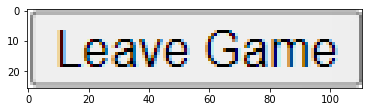

In [11]:
import matplotlib.pyplot as plt
from sewar.full_ref import mse

calibration_r, calibration_c = 138, 1085
calibration_h, calibration_w = 26, 111

SEATS = {0: 'south', 1: 'west', 2: 'north', 3: 'east'}
SEATS_TO_ORDINAL = {y: x for x, y in SEATS.items()}
cards_played = {'south': [], 'west': [], 'north': [], 'east': []}
may_have_suit = {'c': set(range(4)), 'd': set(range(4)), 's': set(range(4)), 'h': set(range(4))}
num_to_card_text = dict(enumerate([x + y for x in 'cdsh' for y in '23456789tjqka']))
card_text_to_num = {y: x for x, y in num_to_card_text.items()}
remaining_cards = set(card_text_to_num)
old_remaining_cards_len = len(remaining_cards)

screenshot= plt.imread('shot.png')
plt.imshow(screenshot[calibration_r:calibration_r+calibration_h,calibration_c:calibration_c+calibration_w,:])


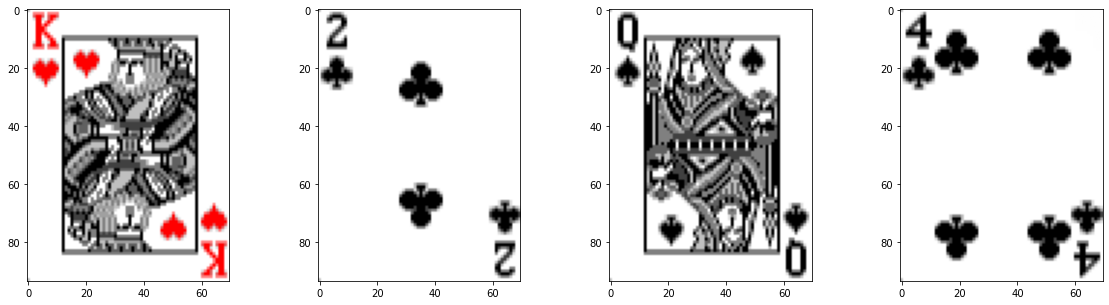

In [240]:
h, w = 94, 70
card_images = {
    'south': screenshot[calibration_r+556:calibration_r+556+h,calibration_c-38:calibration_c-38+w,:3],
    'west': screenshot[calibration_r+496:calibration_r+496+h,calibration_c-118:calibration_c-118+w,:3],
    'north': screenshot[calibration_r+436:calibration_r+436+h,calibration_c-38:calibration_c-38+w,:3],
    'east': screenshot[calibration_r+496:calibration_r+496+h,calibration_c+42:calibration_c+42+w,:3]
}
fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
ax[0].imshow(card_images['south'])
ax[1].imshow(card_images['west'])
ax[2].imshow(card_images['north'])
ax[3].imshow(card_images['east'])


In [242]:
def get_mse(img, card_text):
    card = plt.imread('cards/' + card_text + '.png')[:,:,:3]
    return mse(img, card)

def get_cards_str(card_texts, sep='  '):
    grouped_cards = [
        sorted([x for x in card_texts if x[0] == suit_text], key=lambda z: -card_text_to_num[z])
        for suit_text in 'cdsh'
    ]
    return sep.join([''.join([x[1].upper() for x in lst]) + ' (' + str(len(lst)) + ')' for lst in grouped_cards])

cards_played = {'south': [], 'west': [], 'north': [], 'east': []}
num_to_card_text = dict(enumerate([x + y for x in 'cdsh' for y in '23456789tjqka']))
card_text_to_num = {y: x for x, y in num_to_card_text.items()}
remaining_cards = set(card_text_to_num)
old_remaining_cards_len = len(remaining_cards)


for seat, player_card in card_images.items():
    _match = []
    for card_text in card_text_to_num:
        _match.append((get_mse(player_card, card_text), card_text))

    card_mse, matched_card = sorted(_match)[0]
    fine_matches = {'da'}
    if matched_card not in remaining_cards or (
        card_mse > 0.03 and matched_card not in fine_matches or card_mse > 0.015 and matched_card in fine_matches):
        break
    remaining_cards.remove(matched_card)
    cards_played[seat].append(matched_card)


if len(remaining_cards) < old_remaining_cards_len:
    old_remaining_cards_len = len(remaining_cards)
    for seat, x in cards_played.items():
        print(seat + ' ' * (7-len(seat)), ' '.join(x))
        print(get_cards_str(x))

    print('remaining (' + str(len(remaining_cards)) + '):')
    print(get_cards_str(remaining_cards, sep='\n'))
    
print()
print('remaining ', get_cards_str(remaining_cards))


remaining  AKQJT98765432 (13)  AKQJT98765432 (13)  AKQJT98765432 (13)  AKQJT98765432 (13)


In [520]:
len('py:18: UserWarning: Supplied image')

34